In [ ]:
# Spectogram library
import sys
!conda install --yes --prefix {sys.prefix} librosa


In [1]:
# Imports available via the AWS Sagemaker python3 kernel.
import colorsys
import glob
import io
import math
import random
from collections import namedtuple

import librosa
import librosa.display
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from PIL import Image

%matplotlib inline
plt.ioff()


In [2]:
# Define where the files of bat recordings in .wav format are located.
directory = '../v1.1.0/data/wav'
files = glob.glob('{}/**/*.wav'.format(directory), recursive=True)

# Take a matplotlib figure and return it as an image buffer.
def fig2data(fig):
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8)
    buf.shape = (h, w, 3)
    return buf

# Subtract the median values of each row and column from every pixel in 
# the array and then clip all pixels with resulting values < 0.
def _denoise_spec(spec):
    spec = spec - np.median(spec, axis=1, keepdims=True)
    spec = spec - np.median(spec, axis=0, keepdims=True)
    spec.clip(min=0, out=spec)
    return spec

In [6]:
# Pick a random file and print it.
random.shuffle(files)
file = files[0]
print(file)


../v1.1.0/data/wav/MYGR/p000_g55917_i384.wav


In [11]:

# Plot a single spectrogram containing multiple potential pulses.
def make_large_spectrogram(sig, sr, name, low=5000, high=100000):

    root_size = int(0.001 * sr)  # 1.0ms resolution
    hop_length = int(root_size/4)
    fig = plt.figure(figsize=(10, 2), dpi=100)
    ax = fig.add_axes([0, 0, 1, 1])
    plt.margins(0)

    ax.clear()

    # Plot
    librosa.display.specshow(
        sig, sr=sr, hop_length=hop_length, x_axis='s', y_axis='linear', ax=ax)

    ax.set_ylim(low, high)

    plt.xlabel('time (s)')
    plt.ylabel('Frequency Hz')

    fig.savefig(name, dpi=100, bbox_inches='tight', pad_inches=0)
    return name


# Plot a spectrogram containing a single potential pulse.
def make_small_spectrograms(sig, sr, name, low=5000, high=100000):

    root_size = int(0.001 * sr)  # 1.0ms resolution
    hop_length = int(root_size/4)
    fig = plt.figure(figsize=(1, 1), dpi=100)
    ax = fig.add_axes([0, 0, 1, 1])
    plt.margins(0)
    ax.clear()

    # Plot
    librosa.display.specshow(
        sig, sr=sr, hop_length=hop_length, x_axis='s', y_axis='linear', ax=ax)

    ax.set_ylim(low, high)
    ax.axis('off')

    fig.savefig(name, dpi=100, bbox_inches='tight', pad_inches=0)
    return name


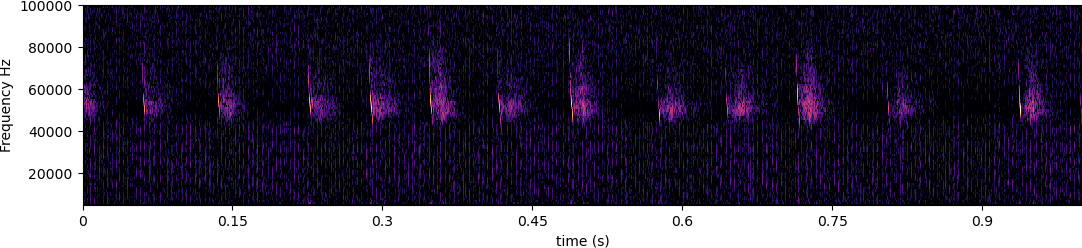

In [12]:

# Load the file and crop along horizontal axis to represent first 1000 ms.
sig, sr = librosa.load(file, sr=None)  # read the wav file
sig = sig[0*sr:1*sr]

root_size = int(0.001 * sr)  # 1.0ms resolution
hop_length = int(root_size/4)

# Short-time Fourier Transform.
stft_spec_window = librosa.stft(sig, n_fft=root_size, hop_length=hop_length, win_length=root_size,
                                window='hamming')

# Calculate and filter data for the spectrogram.
stft_spec_window = np.abs(stft_spec_window) ** 2
stft_spec_window = librosa.power_to_db(stft_spec_window)
frequency_bands = librosa.fft_frequencies(sr=sr, n_fft=root_size)

# Set bandpass filter from 5-100 kHz
for i, b in enumerate(frequency_bands):
    if b <= 5000 or b >= min(100000, (sr / 2) - 2000):
        stft_spec_window[i] = [-500] * len(stft_spec_window[i])

# Plot the spectrogram.
stft_spec_window = _denoise_spec(stft_spec_window)
img = make_large_spectrogram(stft_spec_window, sr, '1.png')
Image.open('1.png').show()
plt.close('all')


Time: 112.0 ms, Frequency: 52000.0 Hz, SNR: 19.48, Amplitude: 36.52 db


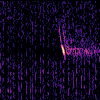

Time: 186.75 ms, Frequency: 53000.0 Hz, SNR: 14.69, Amplitude: 32.40 db


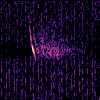

Time: 278.0 ms, Frequency: 53000.0 Hz, SNR: 17.51, Amplitude: 33.42 db


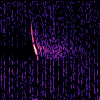

Time: 339.25 ms, Frequency: 52000.0 Hz, SNR: 18.36, Amplitude: 34.19 db


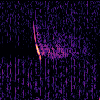

Time: 398.75 ms, Frequency: 54000.0 Hz, SNR: 17.18, Amplitude: 36.14 db


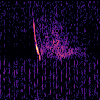

Time: 467.25 ms, Frequency: 53000.0 Hz, SNR: 18.61, Amplitude: 36.43 db


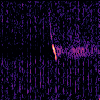

Time: 539.25 ms, Frequency: 54000.0 Hz, SNR: 21.78, Amplitude: 41.58 db


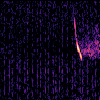

Time: 627.5 ms, Frequency: 48000.0 Hz, SNR: 19.60, Amplitude: 38.04 db


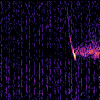

Time: 695.75 ms, Frequency: 49000.0 Hz, SNR: 11.22, Amplitude: 24.66 db


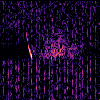

Time: 765.75 ms, Frequency: 56000.0 Hz, SNR: 13.14, Amplitude: 33.84 db


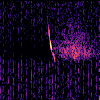

Time: 856.75 ms, Frequency: 50000.0 Hz, SNR: 12.58, Amplitude: 28.99 db


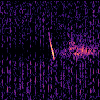

Time: 988.25 ms, Frequency: 51000.0 Hz, SNR: 27.07, Amplitude: 46.38 db


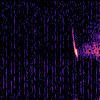

In [20]:


# Load the file and crop along horizontal axis to represent first 1000 ms.
sig, sr = librosa.load(file, sr=None)  # read the wav file
sig = sig[0*sr:1*sr]

# Loop over file and create sampling windows.
for i in range(50, min(math.ceil((len(sig) / float(sr)) * 1000), 99999999), int(50 * (1 - 0.4))):
    start = (i - 50) / \
        1000  # where to start in seconds
    end = i/1000  # where to end in seconds
    # Get the portion of the signal we are interested in.
    fsig = sig[int((start * sr)):int((end * sr))]

    root_size = int(0.001 * sr)  # 1.0ms resolution
    hop_length = int(root_size/4)

    # Short-time Fourier Transform
    stft_spec_window = librosa.stft(fsig, n_fft=root_size, hop_length=hop_length, win_length=root_size,
                                    window='hamming')

    # Calculate and filter data for the spectrogram.
    stft_spec_window = np.abs(stft_spec_window) ** 2
    stft_spec_window = librosa.power_to_db(stft_spec_window)

    frequency_bands = librosa.fft_frequencies(sr=sr, n_fft=root_size)

    # Set bandpass filter from 5-100 kHz.
    for j, b in enumerate(frequency_bands):
        if b <= 5000 or b >= min(100000, (sr / 2) - 2000):
            stft_spec_window[j] = [-500] * len(stft_spec_window[j])

      # Find the index value for the loudest sound in the spectrogram,
      # which is hopefully a bat pulse.
    index = np.unravel_index(
        stft_spec_window.argmax(), stft_spec_window.shape)
    time_index = index[1]  # time
    frequency_index = index[0]  # frequency

    # Convert index values to real values of seconds and Hz.
    peak_frequency = frequency_bands[frequency_index]
    peak_time = time_index/4

    # Make sure the peak frequency of each spectrogram is within bat frequency range
    # and does not overlap the analysis matrix edge.
    if peak_time < 50 * 0.2 or peak_time > 50 * 0.8:
        continue
    elif peak_frequency <= 5000 or peak_frequency >= min(100000, (sr / 2) - 2000):
        continue

    # Denoise the sonogram after finding peak time and frequency.
    stft_spec_window = _denoise_spec(stft_spec_window)

    # Calculate window characteristics.
    freq_amp = stft_spec_window[frequency_index]
    r_other = np.sum(stft_spec_window) / \
        (len(stft_spec_window) * len(stft_spec_window[0]))
    rsig = sum(freq_amp[time_index - 4: time_index + 6]) / 10
    signal_noise_ratio = rsig/r_other
    amplitude = freq_amp[time_index]

    if signal_noise_ratio >= 7 and amplitude >= 21:
        print('Time: {} ms, Frequency: {} Hz, SNR: {:.2f}, Amplitude: {:.2f} db'.format(i + peak_time, peak_frequency, signal_noise_ratio, amplitude))
        img = make_small_spectrograms(
            stft_spec_window, sr, '{}y.png'.format(i))
        Image.open('{}y.png'.format(i)).show()
